# Load SP500 stock data using Yahoo Finance

In [20]:
# !pip install yfinance

In [1]:
import pandas as pd
import datetime
import yfinance as yf

In [2]:
# get sp500 list from wikipedia by pandas
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(url)
sp500 = sp500[0][["Symbol", "Date added"]]

# Fill NaN values with a default date
# Fill NaN values with a default date
sp500['Date added'] = sp500['Date added'].fillna('1900-01-01')

# Convert 'Date added' to datetime format
sp500['Date added'] = pd.to_datetime(sp500['Date added'], errors='coerce', format='%Y-%m-%d')

end_time = datetime.datetime.today()
start_time = end_time - pd.DateOffset(months = 26)

# Select sp500_list where 'Date added' is before start_time
sp500_list = sp500[sp500["Date added"] <= start_time]["Symbol"].tolist()

In [3]:
# download data from yahoo finance
data_1d = yf.download(sp500_list, start = start_time, end = end_time, interval = "1d")["Adj Close"]


[*********************100%%**********************]  468 of 468 completed

2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-05-10 16:39:48.481531 -> 2024-07-10 16:39:48.481531)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


# Deriving highly correlated stock combinations for pair trading

## Split Data into Two Parts

The data is divided into two parts:

1. A 24-month period for the correlation matrix and portfolio optimization.
2. A 60-day period for reassurance for backtesting with high frequency (Intraday).

In [5]:
# split data into two parts

# 24 months for correlation matrix & portfolio optimization
start_time_cor_backtesting = start_time 
final_time_cor_backtesting = end_time - pd.DateOffset(days = 60)

# 60 days for reassurance for backtesting with high frequency (Intraday)
start_time_reassurance = final_time_cor_backtesting + pd.DateOffset(days = 1)
final_time_reassurance = end_time

# check if the duration of reassurance is 60 days which means the difference between final_time_reassurance and start_time_reassurance is 59 days
print(final_time_reassurance - start_time_reassurance)


59 days 00:00:00


In [6]:
data_1d_corr = data_1d.loc[start_time_cor_backtesting:final_time_cor_backtesting].copy() #inclusive:inclusive
correlation_matrix = data_1d_corr.corr()
correlation_matrix

Ticker,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.226509,-0.320114,0.456032,0.453381,-0.010701,-0.312475,0.199780,0.115864,0.312451,...,0.584373,0.106118,0.211331,0.147278,0.311348,0.553092,0.299452,0.303057,0.335923,-0.197359
AAL,0.226509,1.000000,0.076361,-0.073382,0.442953,0.062474,-0.025883,0.285694,0.072315,-0.087085,...,0.102512,0.456378,0.278847,0.161980,0.002702,0.196655,0.260598,0.563395,0.600978,0.162392
AAPL,-0.320114,0.076361,1.000000,0.210440,0.195871,0.752530,0.850985,0.732591,-0.541572,0.319532,...,0.307605,0.281289,0.506275,-0.488168,0.293378,0.440616,0.570306,0.362891,-0.293784,0.733048
ABBV,0.456032,-0.073382,0.210440,1.000000,0.552488,0.588836,0.373893,0.569603,-0.606639,0.489896,...,0.754377,0.313633,0.438932,-0.513256,0.506266,0.697948,0.595311,0.266573,-0.117646,0.313221
ABT,0.453381,0.442953,0.195871,0.552488,1.000000,0.547567,0.293285,0.463140,-0.415844,0.234924,...,0.547877,0.668583,0.246138,-0.039344,0.055228,0.526166,0.491056,0.491084,0.374964,0.449848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.553092,0.196655,0.440616,0.697948,0.526166,0.579376,0.365023,0.740665,-0.461357,0.576349,...,0.871505,0.208880,0.622312,-0.479232,0.654075,1.000000,0.811649,0.572408,-0.053434,0.198410
YUM,0.299452,0.260598,0.570306,0.595311,0.491056,0.524115,0.452710,0.878360,-0.493455,0.302548,...,0.728244,0.188252,0.867815,-0.459059,0.712944,0.811649,1.000000,0.777159,-0.081928,0.433721
ZBH,0.303057,0.563395,0.362891,0.266573,0.491084,0.213888,0.130194,0.676996,-0.178341,-0.003075,...,0.484501,0.138822,0.778402,-0.064017,0.447820,0.572408,0.777159,1.000000,0.203376,0.279339


In [7]:
correlation_values = correlation_matrix.values.flatten()
correlation_values = correlation_values[(correlation_values != 1)]
print(correlation_values)

[ 0.22650943 -0.32011416  0.45603199 ...  0.43372065  0.27933859
 -0.05509399]


In [8]:
import numpy as np

# Create a boolean mask for the upper triangle of the matrix
mask_upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1)

# Apply the mask to the correlation matrix, this will remain values only in the upper triangle
upper_corr_matrix = np.multiply(correlation_matrix, mask_upper_triangle)

# Reshape the DataFrame from a 2D table to a 1D series, preserving row and column labels
stacked_corr = upper_corr_matrix.stack()

# Sort the correlation values in descending order
sorted_corr = stacked_corr.sort_values(ascending=False)

# Select the top 3000 pairs
high_correlated_pairs = sorted_corr.index[0:3000].tolist()

# Time Series Analysis of Highly Correlated Stocks: Interactive Charts with Plotly

In [9]:
from ipywidgets import interact, Output, widgets
from plotly import graph_objs as go
from IPython.display import display, clear_output


# Create dropdown widget for pairs
pair_dropdown = widgets.Dropdown(
    options=[(pair, pair) for pair in high_correlated_pairs],
)

# Create the output widget for displaying the plot
plot_output = Output()

# Display the empty output widget once
display(plot_output)

# Function to update graph
def update_graph(selected_pair):
    with plot_output:
        # remove the graph in the output cell already
        clear_output(wait=True)
        # Extract individual stocks from the selected pair
        
        fig = go.Figure()
        
        # Add trace for stock1 using the primary y-axis
        fig.add_trace(go.Scatter(x = data_1d.index, y = data_1d[selected_pair[0]], name = selected_pair[0], yaxis = "y1"))
        
        # Add trace for stock2 using the secondary y-axis       
        fig.add_trace(go.Scatter(x = data_1d.index, y = data_1d[selected_pair[1]], name = selected_pair[1], yaxis = "y2"))
        # Update layout to include a second y-axis
        fig.update_layout(
            yaxis=dict(title=selected_pair[0], titlefont=dict(color="blue"), tickfont=dict(color="blue")),
            yaxis2=dict(title=selected_pair[1], titlefont=dict(color="red"), tickfont=dict(color="red"), overlaying="y", side="right"),
            title="Stock Prices Over Time",
            xaxis_title="Date"
        )

        
        
        fig.show()

# Create interactive widget
interact(update_graph, selected_pair=pair_dropdown);

Output()

interactive(children=(Dropdown(description='selected_pair', options=((('GOOG', 'GOOGL'), ('GOOG', 'GOOGL')), (…

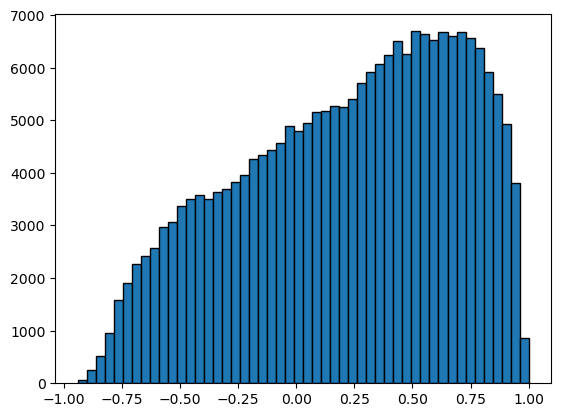

In [10]:
import matplotlib.pyplot as plt
# plot histogram
plt.hist(correlation_values, bins = 50, edgecolor = "black")
plt.show()

# Implementation of Pair Trading Strategy: OOP Part 1

### CLASS & OBJECT
    - Classes are used to create and utilize objects.
    - An object is a concrete instance of a class and is a programming component that possesses attributes and behaviors (methods).
    - Arguments are input into a class.
    - These arguments are assigned to the attributes of the object.
    - Object creation is accomplished through __init__(self, **args).

## PairTradingFinancialAnalysis Class Creation

In [71]:
class PairTradingFinancialAnalysis:

    # attributes (속성)
    def __init__(self, pair, df_whole, window, zscore_threshold, margin_init, margin_ratio):
        """
        Initialize the PairTrading object.

        Parameters:
        - pair (tuple): A tuple containing the names of the two stocks in the pair.
        - df_whole (DataFrame): The whole DataFrame containing the historical stock data.
        - window (int): The size of the rolling window used for calculating z-scores.
        - zscore_threshold (float): The threshold value for determining trading signals based on z-scores.
        - margin_init (float): The initial margin value for trading.
        - margin_ratio (float): The ratio used for adjusting the margin value.

        Attributes:
        - stock1 (str): The name of the first stock in the pair.
        - stock2 (str): The name of the second stock in the pair.
        - window (int): The size of the rolling window used for calculating z-scores.
        - zscore_threshold (float): The threshold value for determining trading signals based on z-scores.
        - margin_init (float): The initial margin value for trading.
        - margin_ratio (float): The ratio used for adjusting the margin value.
        - margin (float): The current margin value.
        - df_pair (DataFrame): A DataFrame containing the historical data of the pair of stocks.
        - df_signal_summary (DataFrame): A DataFrame for storing the trading signals.
        - df_margin (DataFrame): A DataFrame for storing the margin values.
        
        methods:
        - zscore_calculation: Calculate the z-scores for the pair of stocks.
        - signal_calculation: Calculate the trading signals based on the z-scores.
        - signal_summary: Summarize the trading signals.
        - margin_calculation: Calculate the margin values for trading.
        - trading_summary: Provide a summary of the pair trading strategy.

        """
        self.stock1, self.stock2 = pair[0], pair[1]
        self.window = window
        self.zscore_threshold = zscore_threshold
        self.margin_init = margin_init
        self.margin_ratio = margin_ratio
        self.margin = margin_init
        self.df_pair = df_whole.loc[:, pair].copy()
        self.df_signal_summary = pd.DataFrame()
        self.df_margin = pd.DataFrame()
        
    def __repr__(self): 
        return f"""PairTradingFinancialAnalysis(pair = {self.stock1} and {self.stock2}, window = {self.window}, zscore_threshold = {self.zscore_threshold}, 
                    margin_init = {self.margin_init}, margin_ratio = {self.margin_ratio})"""
    
    # methods (메소드)
    def zscore_calculation(self):
        """
        Calculates the z-score for a given stock pair based on the moving average and moving standard deviation of their price ratio.

        Attributes:
            - self.pair (tuple): Contains the symbols of the two stocks in the pair to be analyzed.
            - self.df_pair (DataFrame): Contains the price data for the two stocks.
            - self.window (int): The size of the rolling window for which the moving average and moving standard deviation are calculated.

        Updates:
            - The method updates self.df_pair by adding new columns:
                - "ratio": The ratio of the prices of the two stocks.
                - "ma": The moving average of the price ratio.
                - "msd": The moving standard deviation of the price ratio.
                - "zscore": The z-score calculated from the price ratio, moving average, and moving standard deviation.
        """
        self.df_pair["ratio"] = self.df_pair[self.stock1] / self.df_pair[self.stock2]
        self.df_pair["ma"] = self.df_pair["ratio"].rolling(window=self.window).mean().shift(1)
        self.df_pair["msd"] = self.df_pair["ratio"].rolling(window=self.window).std().shift(1)
        self.df_pair["zscore"] = (self.df_pair["ratio"] - self.df_pair["ma"]) / self.df_pair["msd"]

    
    def signal_calculation(self):
        """
        Calculates trading signals based on the comparison between z-score and z-score threshold.

        Attributes:
            - self.df_pair (DataFrame): DataFrame obtained from zscore_calculation.
            - self.zscore_threshold (float): Threshold value used to determine trading signals.

        Updates:
            - Updates self.df_pair to include z-score (proportional to stock1/stock2), z-score threshold, and signals.
            - If z-score > z-score_threshold and z-score < 5, it indicates that stock1 is statistically overvalued compared to stock2. This suggests shorting stock1 and going long on stock2, represented by signal = -1.
            - If z-score < -z-score_threshold and z-score > -5, it indicates that stock1 is statistically undervalued compared to stock2. This suggests going long on stock1 and shorting stock2, represented by signal = 1.
            - If z-score is between -1 and 1, it indicates that neither stock1 nor stock2 is statistically significantly valued. This suggests not to buy or sell either stock, represented by signal = 0.
            - If z-score is greater than 5 or less than -5, no trading is performed. This is because such cases are too far from the statistical norm (for example, a stock price crash), and changing any decision could be risky.
            - If none of the above cases apply, it means to maintain the signal. The existing signal is filled forward using ffill(), and the remaining NaN values are filled with 0.
        """
        import numpy as np
        self.df_pair['signal'] = np.nan
        self.df_pair['signal'] = np.where((self.df_pair['zscore'] > self.zscore_threshold) & (self.df_pair['zscore'] < 5), -1, self.df_pair['signal'])
        self.df_pair['signal'] = np.where((self.df_pair['zscore'] < -self.zscore_threshold) & (self.df_pair['zscore'] > -5), 1, self.df_pair['signal'])
        self.df_pair['signal'] = np.where((self.df_pair['zscore'] > -1) & (self.df_pair['zscore'] < 1), 0, self.df_pair['signal'])
        self.df_pair['signal'] = self.df_pair['signal'].ffill()
        self.df_pair['signal'] = self.df_pair['signal'].fillna(0)                                

    def signal_summary(self):
        """
        Groups self.df_pair based on signal, calculates start and end dates, start and end prices, and creates self.df_signal_summary.

        Attributes:
            - self.df_pair (DataFrame): DataFrame obtained from signal_calculation.

        Returns:
            DataFrame: Creates self.df_signal_summary which includes start and end dates, start and end prices, and signals.
        """ 
        self.df_pair["signal_group"] = self.df_pair["signal"].diff().ne(0).cumsum() 
        self.df_pair["time"] = self.df_pair.index
        self.df_signal_summary = (self.df_pair
                           .groupby("signal_group")
                           .agg({"signal": "first", 
                                "time": "first", 
                                self.stock1: ["first"], 
                                self.stock2: ["first"]})
                            .reset_index(drop=True)
                            )
        self.df_signal_summary.columns = ["signal", "time_start","stock1_start_price", "stock2_start_price"]
        
        self.df_signal_summary["time_end"] = self.df_signal_summary["time_start"].shift(-1)
        self.df_signal_summary["stock1_final_price"] = self.df_signal_summary["stock1_start_price"].shift(-1)
        self.df_signal_summary["stock2_final_price"] = self.df_signal_summary["stock2_start_price"].shift(-1)
        
        self.df_signal_summary.loc[self.df_signal_summary.index[-1], "time_end"] = self.df_pair.index[-1]
        self.df_signal_summary.loc[self.df_signal_summary.index[-1], "stock1_final_price"] = self.df_pair[self.stock1].iloc[-1]
        self.df_signal_summary.loc[self.df_signal_summary.index[-1], "stock2_final_price"] = self.df_pair[self.stock2].iloc[-1]

        # reorder columns
        self.df_signal_summary = self.df_signal_summary[["signal", "time_start", "time_end", "stock1_start_price", "stock1_final_price", "stock2_start_price", "stock2_final_price"]]
   
    def margin_calculation(self):
        '''
        This function calculates the margin (collateral for assets and leverage) considering the "commission" and "price adjustment" when buying and selling a pair of stocks.
        https://www.interactivebrokers.com/en/pricing/commissions-stocks.php 

        Commission details:  
            - Buy commission: $0.005 per share (minimum $1, maximum 1% of transaction value) 
            - Sell commission: $0.005 per share (minimum $1, maximum 1% of transaction value) + 0.000008 of the sale value (SEC Transaction Fee) + $0.000166 per share (FINRA Trading Activity Fee)  

        Price adjustment:
            - Buy & Sell price: Conservatively, we will adjust the price by 3 pips. Typically, 1.5 pips (1 pip = 0.0001) is used.
            - Buy & Sell price: 1.0003 (buy) & 0.9997 (sell) --> Ultimately, price adjustment is for the broker's profit.

        Attributes:
            - self.margin_init (float): The initial collateral amount.
            - self.margin_rate (float): The margin ratio of the leverage account. For example, if the margin is 3000 and the margin ratio is 0.25, the total investment amount of the leverage account is 12,000.
            - self.df_signal_summary (DataFrame): DataFrame created from signal_summary. 
        
        Returns:
            - DataFrame: Creates df_margin by copying from self.df_signal_summary and updates it by calculating the margin.
        '''

        import math
        # Initial buying power and margin setup
        
        margin = self.margin_init
        buying_power = margin/ self.margin_ratio

        # Calculate margin for each stock pair
        df_margin = self.df_signal_summary.copy()
        df_margin = df_margin[df_margin['signal'].isin([1, -1])]

        for index, row in df_margin.iterrows(): # https://www.w3schools.com/python/pandas/ref_df_iterrows.asp
            # Calculate the number of units for each stock pair
            stock1_units = math.floor((0.5 * buying_power) / row["stock1_start_price"])
            stock2_units = math.floor((0.5 * buying_power) / row["stock2_start_price"])
            
            # Calculate commissions for buying and selling
            if row["signal"] == 1:
                commision_buy = min(max(stock1_units * 0.005, 1), 0.5 * buying_power * 0.01)
                commision_sell = min(max(stock2_units * 0.005, 1), 0.5 * buying_power * 0.01) + 0.000008 * 0.5 * buying_power + 0.000166 * stock2_units
                total_commission = commision_buy + commision_sell
            else:
                commision_buy = min(max(stock2_units * 0.005, 1), 0.5 * buying_power * 0.01)
                commision_sell = min(max(stock1_units * 0.005, 1), 0.5 * buying_power * 0.01) + 0.000008 * 0.5 * buying_power + 0.000166 * stock1_units
                total_commission = commision_buy + commision_sell

            # Calculate margin based on signal
            if row["signal"] == 1: # Buy stock1 and sell stock2
                margin += ((row["stock1_final_price"] * 0.9997 - row["stock1_start_price"] * 1.0003) * stock1_units - 
                           (row["stock2_final_price"] * 1.0003 - row["stock2_start_price"] * 0.9997) * stock2_units) - total_commission
            else:
                margin += ((row["stock2_final_price"] * 0.9997 - row["stock2_start_price"] * 1.0003) * stock2_units - 
                           (row["stock1_final_price"] * 1.0003 - row["stock1_start_price"] * 0.9997) * stock1_units) - total_commission

            # Update margin and buying power for each iteration
            df_margin.loc[index, "margin"] = margin
            buying_power = margin / self.margin_ratio
            self.margin = margin
            
        self.df_margin = df_margin
  

    def trading_summary(self):
        """
        Provides a summary of the pair trading strategy.

        Attributes:
            - self.df_summary (DataFrame): The DataFrame obtained from margin_calculation.

        Returns: 
        Returns a dictionary containing the following information:
            - 'pair': The pair being analyzed.
            - 'window': The number of days used to calculate the moving average.
            - 'zscore_threshold': The threshold value used to determine the trading signal.
            - 'margin': The margin after trading.
        """
        self.zscore_calculation()
        self.signal_calculation()
        self.signal_summary()
        self.margin_calculation()
        trading_result = {
            'pair': (self.stock1, self.stock2),
            'window': self.window,
            'zscore_threshold': self.zscore_threshold,
            'margin': self.margin
        }
        return trading_result


In [73]:
PairTradingFinancialAnalysis_obj = PairTradingFinancialAnalysis(pair = ("MSFT", "AAPL"), df_whole = data_1d[start_time_cor_backtesting:final_time_cor_backtesting], window = 10, zscore_threshold = 2.0, margin_init = 3000, margin_ratio = 0.25)
PairTradingFinancialAnalysis_obj.zscore_calculation()
PairTradingFinancialAnalysis_obj.signal_calculation()
PairTradingFinancialAnalysis_obj.signal_summary()
PairTradingFinancialAnalysis_obj.margin_calculation()
PairTradingFinancialAnalysis_obj.trading_summary()

{'pair': ('MSFT', 'AAPL'),
 'window': 10,
 'zscore_threshold': 2.0,
 'margin': 4001.852956884939}

## Parallel Processing Implementation by List Comprehension and Joblib

### List Comprehension Application

In [74]:
def trading_summary_wt_parameters(df_whole, pair, margin_init, margin_ratio):
    pair_trading_summary_ls = [
        PairTradingFinancialAnalysis(df_whole = df_whole, pair = pair, margin_init = margin_init, margin_ratio = margin_ratio, window = window, 
                                     zscore_threshold = zscore_threshold).trading_summary()
        for window in range(3,30,1)
        for zscore_threshold in np.linspace(2.0, 4.0, 21)
    ]
    pair_trading_summary_df = pd.DataFrame(pair_trading_summary_ls).sort_values(by='margin', ascending=False)
    return pair_trading_summary_df

In [75]:
data_1d_backtesting = data_1d[start_time_cor_backtesting:final_time_cor_backtesting]

### Joblib Application for Parallel Processing

In [76]:
from joblib import Parallel, delayed

In [77]:
import os

num_cores = os.cpu_count()
print(num_cores)

8


In [36]:
pairs_trading_summary = Parallel(n_jobs=num_cores)(delayed(trading_summary_wt_parameters)(df_whole = data_1d_backtesting, margin_init = 3000, margin_ratio = 0.25, 
                                                                                          pair = pair) for pair in high_correlated_pairs)

In [78]:
pairs_trading_summary_df = pd.concat(pairs_trading_summary, ignore_index=True)

In [79]:
if not os.path.exists("../data"):
    os.makedirs("../data")

pairs_trading_summary_df.to_pickle("../data/pairs_trading_summary_df.pkl")

# Deriving Optimal Parameters for PairsTrading through Statistical Methods

In [80]:
top_margin_result = pairs_trading_summary_df.groupby("pair").head(20)
pairs_trading_top20_summary = (
    top_margin_result
    .groupby("pair")
    .agg(
        mean_window=('window', 'mean'),
        median_window=('window', 'median'),
        std_window=('window', 'std'),
        mean_zscore_threshold=('zscore_threshold', 'mean'),
        median_zscore_threshold=('zscore_threshold', 'median'),
        std_zscore_threshold=('zscore_threshold', 'std'),
        mean_margin=('margin', 'mean'),
        median_margin=('margin', 'median'),
        std_margin=('margin', 'std')
    )
    .sort_values(by="mean_margin", ascending=False)
    .reset_index(inplace=False)
)

pairs_trading_top20_summary["dist_window"] = pairs_trading_top20_summary["std_window"] / pairs_trading_top20_summary["mean_window"]
pairs_trading_top20_summary["dist_zscore_threshold"] = pairs_trading_top20_summary["std_zscore_threshold"] / pairs_trading_top20_summary["mean_zscore_threshold"]
pairs_trading_top20_summary["dist_margin"] = pairs_trading_top20_summary["std_margin"] / pairs_trading_top20_summary["mean_margin"]



In [40]:
pairs_trading_top20_summary # If the distribution is too large, it means that the volatility is high, making it difficult to approach the data statistically. Conversely, if the distribution is too small, the optimal situation is concentrated at one point, so even a slight volatility in actual investment will deviate from the optimal situation. Therefore, when deciding on an investment portfolio in the future, we will choose a pair with a moderate distribution.

,pair,mean_window,median_window,std_window,mean_zscore_threshold,median_zscore_threshold,std_zscore_threshold,mean_margin,median_margin,std_margin,dist_window,dist_zscore_threshold,dist_margin
0,"(CTLT, GNRC)",19.45,20.0,2.163696,3.030,3.00,0.152523,20367.037266,19931.602243,2215.716943,0.111244,0.050338,0.108789
1,"(DRI, NFLX)",11.50,11.5,1.933091,2.365,2.40,0.210950,18855.602505,18595.168548,1308.560444,0.168095,0.089197,0.069399
2,"(NFLX, RL)",12.40,12.0,1.569445,2.230,2.20,0.210513,18007.220013,17057.189242,2327.913890,0.126568,0.094401,0.129277
3,"(BIO, PARA)",17.75,16.0,3.905125,2.310,2.20,0.275108,17075.925329,16585.224451,1529.156167,0.220007,0.119094,0.089550
4,"(LLY, NVDA)",15.85,16.0,1.565248,2.660,2.65,0.169830,17061.509602,16352.699610,2478.759926,0.098754,0.063846,0.145284
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,"(BKNG, RCL)",14.10,10.0,8.931906,3.850,3.90,0.135724,2919.593331,2723.897353,489.850562,0.633469,0.035253,0.167780
2996,"(CAT, PH)",9.70,9.0,4.231461,3.620,3.85,0.570872,2893.505084,2900.966191,101.480336,0.436233,0.157699,0.035072
2997,"(AVGO, RCL)",28.05,28.0,0.944513,2.895,2.90,0.308605,2738.523871,2601.335599,244.244840,0.033672,0.106599,0.089189
2998,"(INTU, NVDA)",16.60,13.5,10.580021,3.735,3.80,0.184320,2560.485539,2466.040395,229.397650,0.637351,0.049349,0.089591


# Verifying (Reassurance) Pair Trading Strategy: OOP Part 2

## Getting 5 minute interval data by Yahoo finance

In [41]:
# convert the list of pairs tuple to pure list of stocks
stocks = [stock for pair in high_correlated_pairs for stock in pair]

In [42]:
data_5m_60d = yf.download(
        tickers = stocks,
        period="60d",
        interval="5m"  
    )['Adj Close']

[*********************100%%**********************]  243 of 243 completed


## Creating PairTradingFinancialAnalysisIntraDay Class - Understanding Inheritance and Polymorphism

In [43]:
class PairTradingFinancialAnalysisIntraDay(PairTradingFinancialAnalysis):
    
    def __init__(self, pair, df_whole_intraday, df_whole, window, zscore_threshold, margin_init, margin_ratio):
        """
        - Inherits attributes and methods from the PairTradingFinancialAnalysis parent class for initialization.   
        - The methods of the parent class are zscore_calculation --> signal_calculation --> signal_summary --> margin_calculation --> trading_summary.  
        - The child class overrides the zscore_calculation method of the parent class. This is called polymorphism. Polymorphism means that methods with the same name perform different functions in different classes.

        """
        super().__init__(pair, df_whole, window, zscore_threshold, margin_init, margin_ratio)
        self.df_pair_intraday = df_whole_intraday.loc[:, pair].copy()

    def zscore_calculation(self):
        """
        Calculates the zscore based on the moving average and moving standard deviation of the price ratio for the given stock pair.
        
        Attributes: 
            - self.pair (tuple): A tuple containing the stock symbols of the stock pair to be analyzed.
            - self.df_pair (DataFrame): A DataFrame containing the stock prices of the stocks to be analyzed.
            - self.window (integer): The number of days used to calculate the moving average and moving standard deviation.

        Results:
            - Updates self.df by calculating the zscore by adding the moving average and moving standard deviation from the past of the given window from 1-d interval Data to the current price ratio from IntraDay Data.
        """
        self.df_pair_intraday["Day"] = self.df_pair_intraday.index.date
        self.df_pair_intraday["ratio_intraday"] = np.log(self.df_pair_intraday[self.stock1]/self.df_pair_intraday[self.stock2])

        temp_df = self.df_pair.copy()   # 1-d interval data                                              
        temp_df["Day"] = temp_df.index.date
        temp_df["ratio"] = np.log(temp_df[self.stock1] / temp_df[self.stock2])
        temp_df["ma"] = temp_df["ratio"].rolling(window=self.window).mean().shift(1)
        temp_df["msd"] = temp_df["ratio"].rolling(window=self.window).std().shift(1)
        
        merged_data = pd.merge(self.df_pair_intraday, temp_df, on="Day", how="left", suffixes=("", "_1d"))
        merged_data.index = self.df_pair_intraday.index
        merged_data["zscore"] = (merged_data["ratio_intraday"] - merged_data["ma"])/merged_data["msd"]
        
        self.df_pair = merged_data # update the df_pair with the merged data to 5m interval data

## List Comprehension Application - Return Calculation for Optimal Parameters

In [44]:
def trading_summary_wt_opt_params(pair, df_whole, df_whole_intraday, margin_init, margin_ratio, df_opt_paras):
    import math

    window = int(round(df_opt_paras[df_opt_paras["pair"] == pair]["mean_window"].values[0], 0))
    zscore_threshold = df_opt_paras[df_opt_paras["pair"] == pair]["mean_zscore_threshold"].values[0]
    
    pair_trading_summary = PairTradingFinancialAnalysisIntraDay(
                                pair = pair,    
                                df_whole = df_whole, 
                                df_whole_intraday = df_whole_intraday, 
                                margin_init = margin_init, 
                                margin_ratio = margin_ratio, 
                                window = window, 
                                zscore_threshold = zscore_threshold).trading_summary()
   
    return pair_trading_summary

In [45]:
intraday_trading_summary_ls = [trading_summary_wt_opt_params(
                                    pair = pair, 
                                    df_whole = data_1d, 
                                    df_whole_intraday = data_5m_60d, 
                                    margin_init = 3000, margin_ratio = 0.25, 
                                    df_opt_paras = pairs_trading_top20_summary) for pair in high_correlated_pairs]

In [46]:
intraday_trading_summary_df = pd.DataFrame(intraday_trading_summary_ls).rename(columns={"margin": "intraday_margin"})

In [47]:
intraday_trading_summary_df.intraday_margin.mean()

3047.7222250476234

## Expected Return by Implementing Machine Learning

In [48]:
# merge two dataframes
trading_summary_df = pd.merge(
    pairs_trading_top20_summary, # backtesting with daily interval
    intraday_trading_summary_df, # reassurance with high frequency (Intraday)
    on = "pair", suffixes = ("_1d", "_5m"))

In [49]:
#! pip install -U scikit-learn

In [50]:
trading_summary_df = trading_summary_df.dropna()

In [51]:
# linear regression model with sklearn for x = mean_margin, y = margin
from sklearn.linear_model import LinearRegression

X = trading_summary_df[["mean_margin"]]
y = trading_summary_df["intraday_margin"]
lm = LinearRegression()
lm.fit(X, y)
trading_summary_df["predicted_margin"] = lm.predict(X)


In [52]:
import plotly.graph_objects as go
trading_summary_df["dist_window"] = trading_summary_df["dist_window"].round(2)
trading_summary_df["dist_zscore_threshold"] = trading_summary_df["dist_zscore_threshold"].round(2)
trading_summary_df["dist_margin"] = trading_summary_df["dist_margin"].round(2)
trading_summary_df["mean_margin"] = trading_summary_df["mean_margin"].round(2)
trading_summary_df["intraday_margin"] = trading_summary_df["intraday_margin"].round(2)

# Create a scatter plot
fig = go.Figure()

# Add a scatter plot
fig.add_trace(go.Scatter(
    x=trading_summary_df["mean_margin"],
    y=trading_summary_df["intraday_margin"],
    mode='markers',
    name='Data',
    text=trading_summary_df["pair"],  # add tooltips
    hovertemplate = '<i>Pair</i>: %{text}<br><b>X</b>: %{x}<br><b>Y</b>: %{y}<br>' +
                    '<i>dist_window</i>: %{customdata[0]}<br><i>dist_zscore_threshold</i>: %{customdata[1]}<br><i>dist_margin</i>: %{customdata[2]}<extra></extra>',
    customdata=trading_summary_df[["dist_window", "dist_zscore_threshold", "dist_margin"]].values
))

# Add a trend line
fig.add_trace(go.Scatter(
    x=trading_summary_df["mean_margin"],
    y=trading_summary_df["predicted_margin"],
    mode='lines',
    name='Trend Line',
    line=dict(color='red')
))

# Set labels
fig.update_layout(
    xaxis_title="margin_backtesting",
    yaxis_title="margin_reassurance",
    title="Scatter Plot with Trend Line"
)

fig.show()

## Define the final Investment Portfolio

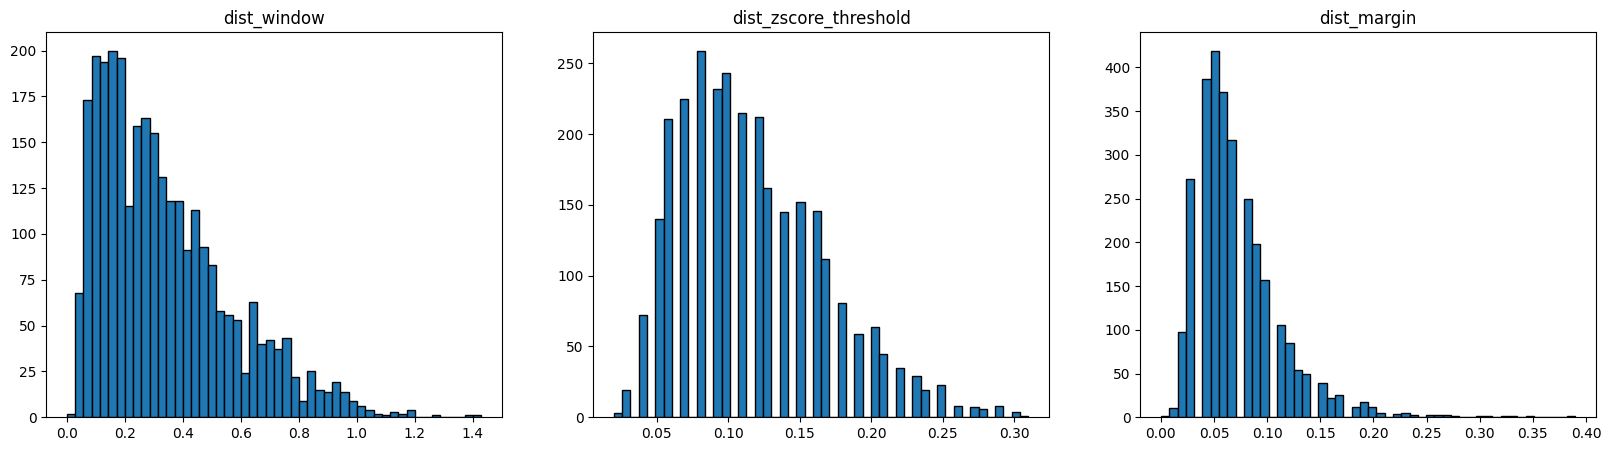

In [53]:
# plot three histograms for window_dist, zscore_threshold_dist, and margin_dist with three subplots
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].hist(trading_summary_df["dist_window"], bins = 50, edgecolor = "black")
ax[0].set_title("dist_window")

ax[1].hist(trading_summary_df["dist_zscore_threshold"], bins = 50, edgecolor = "black")
ax[1].set_title("dist_zscore_threshold")

ax[2].hist(trading_summary_df["dist_margin"], bins = 50, edgecolor = "black")
ax[2].set_title("dist_margin")

plt.show()


In [54]:
trading_summary_df["diff_margin"] = abs(trading_summary_df["intraday_margin"] - trading_summary_df["predicted_margin"])

In [55]:
trading_summary_df.to_pickle("../data/trading_summary_df.pkl")

In [56]:
df_sel = trading_summary_df[(0.2 <= trading_summary_df.dist_window) & (trading_summary_df.dist_window <= 0.3) 
                            & (trading_summary_df.intraday_margin >= 3100) & 
                            (trading_summary_df.diff_margin <= 50)].sort_values(by="intraday_margin", ascending=False).set_index("pair")

In [57]:
df_sel

,mean_window,median_window,std_window,mean_zscore_threshold,median_zscore_threshold,std_zscore_threshold,mean_margin,median_margin,std_margin,dist_window,dist_zscore_threshold,dist_margin,window,zscore_threshold,intraday_margin,predicted_margin,diff_margin
pair,,,,,,,,,,,,,,,,,
"(BIO, PARA)",17.75,16.0,3.905125,2.310,2.20,0.275108,17075.93,16585.224451,1529.156167,0.22,0.12,0.09,18,2.310,3223.57,3197.306147,26.263853
"(ICE, NWSA)",16.00,15.0,3.852545,2.085,2.10,0.087509,12000.91,11779.105159,766.567231,0.24,0.04,0.06,16,2.085,3155.89,3129.776195,26.113805
"(LEN, LIN)",22.75,24.0,4.458876,2.090,2.10,0.091191,9197.24,8871.132281,1008.837979,0.20,0.04,0.11,23,2.090,3130.86,3092.469541,38.390459
"(BSX, IRM)",8.65,10.0,2.158825,2.390,2.40,0.231471,8870.41,8515.197850,805.595555,0.25,0.10,0.09,9,2.390,3117.98,3088.120658,29.859342
"(AMAT, EQIX)",14.70,15.5,3.540740,2.250,2.25,0.213985,9906.28,9820.510342,770.381093,0.24,0.10,0.08,15,2.250,3114.43,3101.904337,12.525663
"(CEG, KLAC)",26.20,27.0,5.578153,2.745,2.70,0.281864,9343.67,9336.126434,901.679316,0.21,0.10,0.10,26,2.745,3113.53,3094.418025,19.111975


In [58]:
def keep_first_occurrence(origin_list):
    # Create a set to keep track of seen stock symbols
    seen = set()
    # Create a result list to keep the non-duplicated pairs
    result = []
    # First, add all the unique pairs from the primary_list to the result
    # If a stock symbol has already been seen, it is a duplicate and will not be added
    for pair in origin_list:
        if pair[0] not in seen and pair[1] not in seen:
            seen.update(pair)
            result.append(pair)
    return seen, result

pairs_set, pairs_list = keep_first_occurrence(df_sel.index)
df_sel = df_sel[df_sel.index.isin(pairs_list)]

In [59]:
df_sel

,mean_window,median_window,std_window,mean_zscore_threshold,median_zscore_threshold,std_zscore_threshold,mean_margin,median_margin,std_margin,dist_window,dist_zscore_threshold,dist_margin,window,zscore_threshold,intraday_margin,predicted_margin,diff_margin
pair,,,,,,,,,,,,,,,,,
"(BIO, PARA)",17.75,16.0,3.905125,2.310,2.20,0.275108,17075.93,16585.224451,1529.156167,0.22,0.12,0.09,18,2.310,3223.57,3197.306147,26.263853
"(ICE, NWSA)",16.00,15.0,3.852545,2.085,2.10,0.087509,12000.91,11779.105159,766.567231,0.24,0.04,0.06,16,2.085,3155.89,3129.776195,26.113805
"(LEN, LIN)",22.75,24.0,4.458876,2.090,2.10,0.091191,9197.24,8871.132281,1008.837979,0.20,0.04,0.11,23,2.090,3130.86,3092.469541,38.390459
"(BSX, IRM)",8.65,10.0,2.158825,2.390,2.40,0.231471,8870.41,8515.197850,805.595555,0.25,0.10,0.09,9,2.390,3117.98,3088.120658,29.859342
"(AMAT, EQIX)",14.70,15.5,3.540740,2.250,2.25,0.213985,9906.28,9820.510342,770.381093,0.24,0.10,0.08,15,2.250,3114.43,3101.904337,12.525663
"(CEG, KLAC)",26.20,27.0,5.578153,2.745,2.70,0.281864,9343.67,9336.126434,901.679316,0.21,0.10,0.10,26,2.745,3113.53,3094.418025,19.111975


In [60]:
print(df_sel.intraday_margin.mean(), df_sel.predicted_margin.mean())

3142.7099999999996 3117.3324838153853


In [61]:
# save df_sel to a pickle file
df_sel.to_pickle("../data/df_sel.pkl")